In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import root_mean_squared_error
from scipy.ndimage import shift
import math

In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("dw|")

dw|


# Preparing data set

In [3]:
NM_data = pd.read_csv('../data/LMKS_NM_1981-2023_hour.csv')
data = pd.read_csv('../data/omni_full_1964-2022.csv')
data

,Unnamed: 0,time1,Rot$,IMF,PLS,IMF_PTS,PLS_PTS,ABS_B,F,THETA_AV,...,F10_INDEX+48,BZ_GSE+1,BZ_GSE+2,BZ_GSE+3,BZ_GSE+4,BZ_GSE+6,BZ_GSE+8,BZ_GSE+12,BZ_GSE+24,BZ_GSE+48
0,0,1963-01-01 01:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1963-01-01 02:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1963-01-01 03:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1963-01-01 04:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1963-01-01 05:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520438,520438,2022-05-13 12:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520439,520439,2022-05-13 13:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520440,520440,2022-05-13 14:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520441,520441,2022-05-13 15:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
NM_data.index = NM_data['Unnamed: 0']
NM_data.drop("Unnamed: 0", axis=1, inplace=True)
NM_data

,H_COR
Unnamed: 0,
1981-12-01 00:00:00,87.2680
1981-12-01 01:00:00,86.9240
1981-12-01 02:00:00,86.8670
1981-12-01 03:00:00,86.4080
1981-12-01 04:00:00,86.5230
...,...
2023-07-10 19:00:00,92.4196
2023-07-10 20:00:00,92.4196
2023-07-10 21:00:00,92.4196


In [5]:
NM_data.dropna(inplace=True)
NM_data.isna().sum()

H_COR    0
dtype: int64

In [6]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.index = data['time1']
data.drop('time1', axis=1, inplace=True)
data

,Rot$,IMF,PLS,IMF_PTS,PLS_PTS,ABS_B,F,THETA_AV,PHI_AV,BX_GSE,...,F10_INDEX+48,BZ_GSE+1,BZ_GSE+2,BZ_GSE+3,BZ_GSE+4,BZ_GSE+6,BZ_GSE+8,BZ_GSE+12,BZ_GSE+24,BZ_GSE+48
time1,,,,,,,,,,,,,,,,,,,,,
1963-01-01 01:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01 02:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01 03:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01 04:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01 05:00:00,1771.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-13 12:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-13 13:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-13 14:00:00,9999.0,99.0,99.0,999.0,999.0,NaN,NaN,NaN,NaN,NaN,...,135.600006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data_relevant = data[['BZ_GSE', 'V', 'N', 'DST', 'SIGMA$Bz']].loc["1995-01-01 00:00:00":]
data_relevant.isna().sum()

BZ_GSE       977
V            903
N           5586
DST            0
SIGMA$Bz     977
dtype: int64

<Axes: xlabel='time1'>

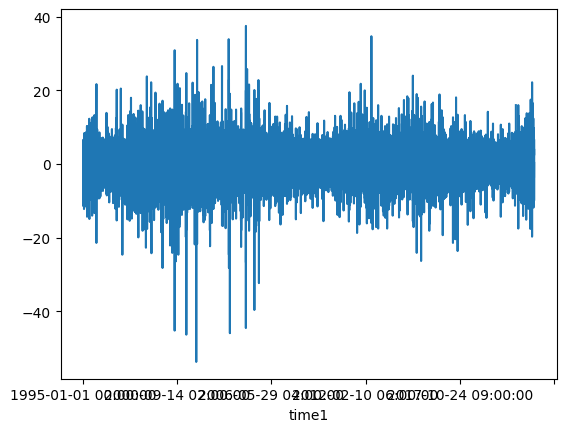

In [8]:
data_relevant["BZ_GSE"].plot()

In [9]:
data_relevant.index = pd.to_datetime(data_relevant.index)
data_relevant_interpolated = data_relevant.interpolate(method='time')
data_relevant_interpolated.isna().sum()

BZ_GSE      0
V           0
N           0
DST         0
SIGMA$Bz    0
dtype: int64

## Intersection of omni data and neutron monitor data

In [10]:
data_relevant_interpolated.index = pd.to_datetime(data_relevant_interpolated.index)
NM_data.index = pd.to_datetime(NM_data.index)

common_index = data_relevant_interpolated.index.intersection(NM_data.index)

data_relevant_interpolated_common = data_relevant_interpolated.loc[common_index]
nm_data_common = NM_data.loc[common_index]

data_relevant_interpolated_common['NM'] = nm_data_common.iloc[:, 0]
data_relevant_interpolated = data_relevant_interpolated_common

data_relevant_interpolated.isna().sum()

BZ_GSE      0
V           0
N           0
DST         0
SIGMA$Bz    0
NM          0
dtype: int64

## Data normalization
- (TODO: apply maximums from Andrejkova paper for normalization)

In [11]:
min_val = data_relevant_interpolated.min()
max_val = data_relevant_interpolated.max()

# Normalize between -1 and 1
data_relevant_interpolated_normalized = 2 * (data_relevant_interpolated - min_val) / (max_val - min_val) - 1
data_relevant_interpolated_normalized

,BZ_GSE,V,N,DST,SIGMA$Bz,NM
1995-01-01 00:00:00,0.131579,-0.818939,-0.763676,0.683367,-0.976134,0.412806
1995-01-01 00:00:00,0.131579,-0.818939,-0.763676,0.683367,-0.976134,0.412806
1995-01-01 01:00:00,0.149123,-0.818939,-0.727206,0.703407,-0.961814,0.405224
1995-01-01 02:00:00,0.168860,-0.808533,-0.719912,0.715431,-0.914081,0.403689
1995-01-01 03:00:00,0.184211,-0.814776,-0.762217,0.711423,-0.961814,0.399131
...,...,...,...,...,...,...
2022-05-13 12:00:00,0.184211,-0.829344,-0.905179,0.699399,-0.904535,0.714550
2022-05-13 13:00:00,0.184211,-0.829344,-0.905179,0.707415,-0.904535,0.715932
2022-05-13 14:00:00,0.184211,-0.829344,-0.905179,0.711423,-0.904535,0.717940
2022-05-13 15:00:00,0.184211,-0.829344,-0.905179,0.711423,-0.904535,0.707895


In [12]:
# np.savetxt('./data/dst.txt', data_relevant_interpolated_normalized['DST'].values, delimiter=',') 

# Generating batches

In [13]:
def generate_batches(a, b, c, d, y, n):
    '''
    Function creates batches out of a, b, c, d data of size 8 hours,
    8-hour window is moved throughout the arrays with step one hour,
    Than all the 8-hour batches are concatenated together to create one big 32 size batch.
    Finally appended to main array.
    
    Also cuts first 8 hours out of y data, so that for every 8 hours of x data
    there is one hour of y data hour ahead of input neurons data. 
    
    Parameters
    ----------
    a - Bz
    b - Sigma Bz
    c - n
    d = v
    y - y training data (DST)
    n - length of event

    Returns
    -------
    batches - Matrix where rows correspond to 8 hours of x array data
          y - y training data (DST) that has first 8 hours cut off
    '''

    y = y[8:]
    y = torch.from_numpy(np.array(y))
    print(y.size())
    print(n)

    batches = []

    for i in range(n):
        if (i+8) <= n:
            # print(i, i+8)
            batch_a = a[i:i+8]
            batch_b = b[i:i+8]
            batch_c = c[i:i+8]
            batch_d = d[i:i+8]

            final_batch = np.concatenate((batch_a, batch_b, batch_c, batch_d), axis=None)

            batches.append(final_batch)

    batches = batches[:-1]
    batches = torch.from_numpy(np.array(batches))

    return batches, y

def generate_batches_var(parameters, y, n, p):
    """
    Generalized batch generator to handle variable parameters and window sizes.
    Parameters:
    - parameters: List of input data arrays (e.g., Bz, Sigma Bz, etc.)
    - y: Target output data array
    - n: Total length of data
    - p: Window size (e.g., 8 hours)
    
    Returns:
    - batches: Tensor of shape (number of batches, p * num_parameters)
    - y: Target output data tensor (adjusted for the window size)
    """
    # Adjust target output data
    y = y[p:]
    y = torch.from_numpy(np.array(y))  # Ensure y is a tensor

    # Prepare batches
    batches = []
    for i in range(n - p):  # Adjust to avoid out-of-bounds indexing
        batch = []
        for param in parameters:
            # Extract the p-window slice for the current parameter
            batch.append(param[i:i + p].numpy())  # Convert tensor to numpy for processing
        # Flatten and concatenate all parameter slices into a single array
        batches.append(np.concatenate(batch))
    
    # Convert the final list of batches to a tensor
    batches = torch.from_numpy(np.array(batches, dtype=np.float32))
    
    return batches, y

In [14]:
Bz       = torch.from_numpy(data_relevant_interpolated_normalized['BZ_GSE'].to_numpy())
Bz_sigma = torch.from_numpy(data_relevant_interpolated_normalized['SIGMA$Bz'].to_numpy())
Bz_sg_s10= torch.from_numpy(data_relevant_interpolated_normalized['SIGMA$Bz'].shift(-10, fill_value=0).to_numpy())
n        = torch.from_numpy(data_relevant_interpolated_normalized['N'].to_numpy())
v        = torch.from_numpy(data_relevant_interpolated_normalized['V'].to_numpy())
DST      = torch.from_numpy(data_relevant_interpolated_normalized['DST'].to_numpy())
BZ_s1    = torch.from_numpy(data_relevant_interpolated_normalized['BZ_GSE'].shift(-1, fill_value=0).to_numpy())
BZ_s2    = torch.from_numpy(data_relevant_interpolated_normalized['BZ_GSE'].shift(-2, fill_value=0).to_numpy())
nv       = n * v
DST_s1   = torch.from_numpy(data_relevant_interpolated_normalized['DST'].shift(1, fill_value=0).to_numpy())
NM       = torch.from_numpy(data_relevant_interpolated_normalized['NM'].to_numpy())

x, y = generate_batches_var(
    [Bz, NM, Bz_sigma, n, v, nv, DST],        # paramters
    DST_s1,                                         # y
    len(data_relevant_interpolated_normalized),  # data size
    8                                            # window
)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_6332\655842599.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = torch.from_numpy(np.array(y))  # Ensure y is a tensor


In [15]:
x.shape, y.shape

(torch.Size([239869, 56]), torch.Size([239869]))

## Splitting test/train

In [16]:
def split(data):
    train_ratio = 0.8
    test_ratio = 1 - train_ratio
    
    # Calculate the split index
    num_train_samples = int(train_ratio * len(data))
    num_test_samples = len(data) - num_train_samples

    
    # Split the data
    train_data = data[:num_train_samples]
    test_data = data[num_train_samples:]

    return train_data, test_data

x_train, x_test = split(x)
y_train, y_test = split(y)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([191895, 56]),
 torch.Size([47974, 56]),
 torch.Size([191895]),
 torch.Size([47974]))

# Create Model

In [17]:
class FFNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size=26, num_layers=1):
        super().__init__()
        
        # Create a list of layers dynamically
        layers = []
        current_size = input_size
        
        # Add hidden layers
        for _ in range(num_layers):
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(0.2))
            current_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(hidden_size, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [18]:
def train(epochs, batch, loss_fn, optim, model, scheduler=None):
    history = []
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(x_train.size()[0])  # Shuffle indices
        
        epoch_loss = 0.0  # To track loss over the entire epoch

        # rnn_tensor = torch.zeros(batch, 8)
        # rnn_tensor = rnn_tensor.to('cuda')
        for b in range(0, x_train.size()[0], batch):  # Corrected batching
            if b + batch > x_train.size()[0]: 
                break
                 
            # rnn_tensor = rnn_tensor.detach()
            
            indices = permutation[b:b+batch]  # Get batch indices
            batch_x, batch_y = x_train[indices], y_train[indices]

            # Move data to correct type
            batch_x = batch_x.to(torch.float32)
            batch_y = batch_y.to(torch.float32)

            # batch_x = torch.cat((batch_x, rnn_tensor), dim=1)

            # Forward pass
            optim.zero_grad()  # Reset gradients
            y_pred = model(batch_x)  # Predict for the entire batch
            loss = loss_fn(y_pred.squeeze(), batch_y)  # Compute batch loss


            # Backward pass and optimization
            loss.backward()  # Compute gradients
            optim.step()  # Update weights
            if not scheduler == None:
                scheduler.step() # update learning rate
            
            # Accumulate loss
            epoch_loss += loss.item()
        
        # Average loss for the epoch
        epoch_loss /= (x_train.size()[0] // batch)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.10f}")
        history.append(epoch_loss)

    return history

## Definovanie fyzikálne informovanej error funkcie
Mozeme si zadefinovat vlastnu error funkciu, ktora bude zahrnovat isty fyzikalny kontext. V tomto pripade to znamena
zahrnut stav $DST$ indexu ako istu vahu pre error. predpokladajme, ze ista hranica kedy sa da povazovat intenzita $DST$ za event je $\leq -50nT$.
Co v preklade do znormalizovanych dat bude priblizne $\leq 0.4nT$. Teda nas $MSE$ budeme nasobit istou vahou podla toho ci predikujeme event alebo nie. Tieto vahy definujeme nasledovnou funkciou:

$$
W(x) =
\begin{cases} 
\psi & \text{if } x \leq \varphi, \\
\xi & \text{if } x > \varphi
\end{cases}
$$

kde $\varphi$ je nejaky treshold, podla predpokladu to bude $0.4$, $\psi$ je nejaka vaha napr.: $5$ a $\xi$ je nejaka zakladna vaha, ta by idelane nemala vela menit, cize napr.: $1$. Tuto piece-wise funkciu mozeme zaplikovat na kazdy element mnoziny realnych hodnot $DST$. Cim nam vznikne mnozina vah pre kazdy error z mnoziny errorov. Nech teda $W$ je mnozina vah, potom vypocet novej error funkcie bude definovany predisom:
$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^N W_{i} \cdot (\hat{Y}_i - Y_i)^2
$$}

In [19]:
class GradientPenaltyMSELoss(torch.nn.Module):
    def __init__(self, lambda_gp=0.1):
        super(GradientPenaltyMSELoss, self).__init__()
        self.lambda_gp = lambda_gp  # Weight of the gradient penalty

    def forward(self, y_pred, y_true):
        # Compute standard MSE
        temp_loss = nn.MSELoss()
        mse_loss = temp_loss(y_pred, y_true)

        # Compute gradient penalty (smoothness)
        gradient = torch.abs(y_pred[1:] - y_pred[:-1])  # Temporal differences
        gradient_penalty = self.lambda_gp * torch.mean(gradient)

        return mse_loss.mean() + gradient_penalty

def nRMSE(o, s):
    MSE = mean_squared_error(o,s)
    return math.sqrt(MSE) / np.std(o)

class DstEventWeightedMSELoss(torch.nn.Module):
    '''
    psi - event treshold
    ksi - event weight
    phi - base weight
    '''
    
    def __init__(self, psi, ksi, phi):
        super(DstEventWeightedMSELoss, self).__init__()

        self.psi = psi
        self.ksi = ksi
        self.phi = phi
        self.mse_loss = nn.MSELoss(reduction='none')
        
    def forward(self, y_pred, y_real):
        losses = self.mse_loss(y_pred, y_real)

        event_weights = torch.where(
            y_real <= self.psi,
            self.ksi,
            self.phi
        )

        return (losses * event_weights).mean()

Epoch 1, Loss: 0.0617671660
Epoch 2, Loss: 0.0157370742
Epoch 3, Loss: 0.0100581718
Epoch 4, Loss: 0.0088292653
Epoch 5, Loss: 0.0073283766
Epoch 6, Loss: 0.0063321166
Epoch 7, Loss: 0.0058115233
Epoch 8, Loss: 0.0047503256
Epoch 9, Loss: 0.0041091736
Epoch 10, Loss: 0.0037027281
Epoch 11, Loss: 0.0029188175
Epoch 12, Loss: 0.0025265742
Epoch 13, Loss: 0.0022167321
Epoch 14, Loss: 0.0016989485
Epoch 15, Loss: 0.0014747619
Epoch 16, Loss: 0.0012466330
Epoch 17, Loss: 0.0009646606
Epoch 18, Loss: 0.0008558092
Epoch 19, Loss: 0.0007220992
Epoch 20, Loss: 0.0005739734
Epoch 21, Loss: 0.0005231220
Epoch 22, Loss: 0.0004659346
Epoch 23, Loss: 0.0004046226
Epoch 24, Loss: 0.0003771713
Epoch 25, Loss: 0.0003500480
Epoch 26, Loss: 0.0003189563
Epoch 27, Loss: 0.0003190127
Epoch 28, Loss: 0.0003082643
Epoch 29, Loss: 0.0002905058
Epoch 30, Loss: 0.0002869050
Epoch 31, Loss: 0.0002896855
Epoch 32, Loss: 0.0002693550
Epoch 33, Loss: 0.0002727897
Epoch 34, Loss: 0.0002656058
Epoch 35, Loss: 0.00025

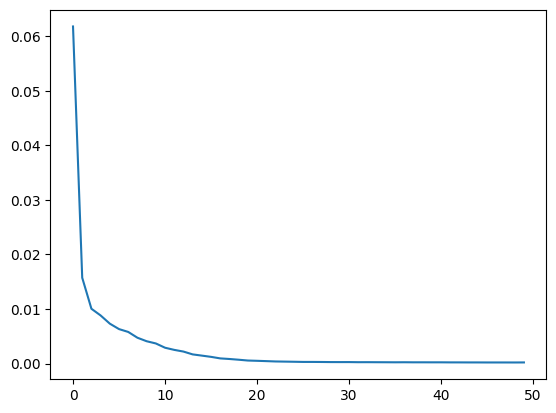

In [20]:
ffnn = FFNN(x_train.size()[1])
ffnn = nn.DataParallel(ffnn)

epochs = 50
alpha_base = 0.00001
alpha_max = 0.0001
batch = 138


# Loss and Optimizer
loss_fn = DstEventWeightedMSELoss(psi=0.5, ksi=4, phi=1)
# loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(ffnn.parameters(), lr=alpha_base, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=alpha_base, max_lr=alpha_max, step_size_up=2000, mode='triangular')

# Start Training
h = train(epochs, batch, loss_fn, optim, ffnn, scheduler)
plt.plot(h)

# Trying predictions

In [21]:
x_train = x_train.to(torch.float32)
y_train = y_train.to(torch.float32)
x_test = x_test.to(torch.float32)
y_test = y_test.to(torch.float32)
x_train.size(), y_train.size(), y_test.size(), x_test.size()

(torch.Size([191895, 56]),
 torch.Size([191895]),
 torch.Size([47974]),
 torch.Size([47974, 56]))

In [22]:
ffnn.eval()
with torch.no_grad():
    y_pred = ffnn(x_test)

In [23]:
%matplotlib qt
plt.plot(y_test.cpu().numpy(), c='b', label='real')
plt.plot(y_pred.cpu().detach().numpy(), c='r', label='prediction')
plt.legend()

In [24]:
mse_ffnn = mean_squared_error(y_pred.cpu().numpy(), y_test.cpu().numpy())
print(f"{mse_ffnn:.10f}")

0.0000102046


In [25]:
y_naive = shift(y_test.cpu().numpy(), 1, cval=0)
mse_naive = mean_squared_error(y_naive, y_test.cpu().numpy())
mse_naive

0.00020148692419752479

In [26]:
1 - (mse_ffnn/mse_naive)

0.9493535298376233

# Shapely values analysis

Nech $\psi$ je nejaky parameter, $P$ je mnozina parametrov a $f : P \rightarrow DST_{t+1}$ je model a $x_0$ je jedna hodnota DST. Potom shapely hodnota parametru $\psi$ v bode $x_0$ je
$$
\varphi_{\psi}(x_0) = \frac{1}{|P|!} \sum_{S \subseteq P \setminus \{\psi\}} |S|!\cdot(|P| - |S| - 1)! \cdot (f(S \cup \{\psi\}) - f(S))
$$
Vypocet si bude vyzadovat postavit niekolko krokov.
- Napjprv je potrebne spravit **mnozinu podmnozin** mnoziny $P$
- Vytvorit **funkciu** ktora **vytvori model s novym poctom parametrov** na vstupe, kedze $f(S)$ bude vzdy predikcia modelu s inym poctom parametrov.
- Skombinovat

## Prepare parameters matrices $\mathbf{P}_{x_0}, \bar{\mathbf{P}}$
This will be the matrices that will be used as the input for the shapely function in this case for FFNN:
$$
\mathbf{P}_{x_0} = 
\begin{pmatrix}
Bz_1 & Bz_2 & \cdots & Bz_8\\
N_1 & N_2 & \cdots & N_8 \\
\vdots & \vdots & \ddots & \vdots\\
DST_1 & DST_2 & \cdots & DST_8
\end{pmatrix},
\mathbf{\bar{P}} = 
\begin{pmatrix}
\bar{Bz} & \bar{Bz} & \cdots & \bar{Bz}\\
\bar{N} & \bar{N} & \cdots & \bar{N} \\
\vdots & \vdots & \ddots & \vdots\\
\bar{DST} & \bar{DST} & \cdots & \bar{DST}
\end{pmatrix}
$$

$\mathbf{P}_{x_0}$ is a matrix with one observation for every parameter needed for prediction, and $\mathbf{\bar{P}}$ is a mtrix with 8 same exact values, the means of parameters corresponding to that row.

In [27]:
params = np.array([
 Bz, NM, Bz_sigma, n, v, nv, DST
])

P_x0 =  x_test[0].numpy().reshape(7,8)
P_bar = np.repeat(params.mean(axis=1), 8)
P_bar = P_bar.reshape(7,8)

## Mnozina podmnozin $P$
Na $S \subseteq P \setminus \{\psi\}$ sa mozeme pozerat trochu inak. V podstate to hovori ze $S$ je kazda podmnozina mnoziny $P$. Preto mozeme zapisat $S$ ako $S \subseteq \mathcal{P(\mathbf{P})}$, cize $S$ je kazda mnozina potencnej mnozinu $P$.

In [28]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [29]:
def power_set_minus(P, target):
    new_P = []
    for i in P:
        if i == target: continue
        else: new_P.append(i)
    power_P = list(powerset(new_P))

    return power_P

def power_set_minus_string(P, target):
    new_p = [P[i] for i in range(len(P)) if P[i] != target]
    return list(powerset(new_p))

## Priprava modelu pre shapely vypocet
Ide hlavne o vytvorenie pomocnych funkcii pre vypocert shapely hodnot v bode a na mnozine.

In [30]:
def f(x0):
    ffnn.eval()
    pred = None
    with torch.no_grad():
        pred = ffnn(x0)

    return pred

In [31]:
f(x_test[0]).numpy()

array([0.6676693], dtype=float32)

## Funkcia vypoctu shapely hodnot

In [32]:
import math

def shapely(mask, target, P_x0, P_bar):
    ps = power_set_minus(mask, target)

    F = 0
    for subset in ps:

        # vypocet rozdielu podmnoziny a hlavnej mnoziny. Cize pre kazdu podmnozinu vytvorit rozdielovu podmnozinu 
        # ktora ma tie prvky co podmnozina nie oproti originalnej mnozine
        subset_diff = []
        for p in [m for m in mask if m != target]:
            truth_table = []
            for s in subset:
                if not s == p: truth_table.append(True)
                else: truth_table.append(False)

            if np.array(truth_table).all().item() and p not in subset_diff:
                subset_diff.append(p)
        
        # input set for prediction f(S)
        S = np.array([np.zeros(8) for _ in range(7)])

        for sd in subset_diff:
            S[sd] = P_bar[sd]
        for s in subset:
            S[s] = P_x0[sd]

        S[target] = P_bar[target]
        S = S.flatten()
            
        # input set for prediction f(S U {target})
        SUT = np.array([np.zeros(8) for _ in range(7)])

        for sd in subset_diff:
            SUT[sd] = P_bar[sd]
        for s in subset:
            SUT[s] = P_x0[sd]

        SUT[target] = P_x0[target]
        SUT = SUT.flatten()

        # making predictions
        S_pred = f(torch.from_numpy(S).float())
        SUT_pred = f(torch.from_numpy(SUT).float())

        # Multiplication factor |S|!*(|S| - |P| - 1)!
        mult = math.factorial(len(subset)) * math.factorial((len(mask) - len(subset) - 1))

        '''
        Finalna suma
        '''
        F += mult * (SUT_pred.item() - S_pred.item())

    return F / math.factorial(len(mask))

    

In [33]:
mask = [0,1,2,3,4,5,6]
mask_str = ['Bz', 'NM', 'Bz_sigma', 'n', 'v', 'nv', 'DST']
target = 5
shapely(mask, target, P_x0, P_bar), mask_str[target]

(0.014674934319087438, 'nv')

## Analyzing shapely values of an event

### Shapely values for all parameters

In [34]:
%%time
event_shapely_values = []

for t in mask:
    current_target_shapely = []
    print(f"Current target: {mask_str[t]}")
    for test in x[77200:77500]:
        test_x0 =  test.numpy().reshape(7,8)

        current_target_shapely.append(shapely(mask, t, test_x0, P_bar))

    event_shapely_values.append(current_target_shapely)


        

Current target: Bz
Current target: NM
Current target: Bz_sigma
Current target: n
Current target: v
Current target: nv
Current target: DST
CPU times: total: 47.4 s
Wall time: 49.2 s


In [ ]:
plt.bar([])

## Plotting graphs

In [39]:
event_shapely_values = np.array(event_shapely_values)

In [41]:
event_shapely_values_mean = event_shapely_values.mean(axis=1)
labels = ["Bz", "NM", "Bz_sigma", "n", "v", "nv", "DST"]
plt.bar(labels, event_shapely_values_mean)

<BarContainer object of 7 artists>

In [37]:
event_shapely_values_mean

array([-2.59668051e-04, -1.39524649e-04,  2.90390799e-05, -3.32533579e-03,
        7.86278969e-02, -7.39187460e-02, -1.68454599e-01])

In [38]:
plt.plot(y[77200:77500])